# Multivariate two factorial ANOVA 

In order to detect masks with early emerging signals we can run varaiance analysis ANOVA. This will tell us if there are differences between SSPs, but will not serve to differantiate new observations. The goal is to detect which masks allows for an early seperation between SSPs, this allows for easier development of ML algs.

Here we run two factorial design hereunder
- Mask as factor, with global levels of nomask, seamask and landmask
- SSP as factor, with levels SSP126, SSP245, SSP370 and SSP585¨
Since all levels of each factor occours in combination we have 12 groups and a crossed model design (in difference to a nested model design). 

We run the factors as descriptive variables for observations of tas, pr, txx and rx5day. Since the interaction between these responsvariables is what will allow us to detect SSP seperation early we use multivariate analysis of variance or MANOVA. 

Since we use a yearly cross-sectional approach for classification we run two-factorial MANOVA on each cross section.  

## Preprocessing of data and initial investigation
In order to enable the analysis we need to transform our data from seperate multivariate time series files on the .nc format, to a table for each seperate cross section (year). The format will be:

| # | Mask | SSP | tas_value | pr_value | txx_value | rx5day_value |
| --|---|---|---|---|---|---|
....

This allows to run the analysis directly if each realization gets one row each. While performing this preprocessing some initial investigations will be performed.


### Investigations of time series ensambles.
It is always important to know the big picture of what you are looking at. Therefor we start by presenting the ensambles of each variable under different masks. In order to calculate the ensambles we use the xclim library. 

**Sources:**
- https://xclim.readthedocs.io/en/stable/index.html
    - https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html

#### Import libraries

In [109]:
from pathlib import Path
from src.preproces import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from xclim import ensembles
import pandas as pd
import xarray as xr


file_handler = Handle_Files()

Support functions for plotting

In [102]:
def legend_without_duplicate_labels(fig):
    handles, labels = fig.axes[0].get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    fig.legend(*zip(*unique), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

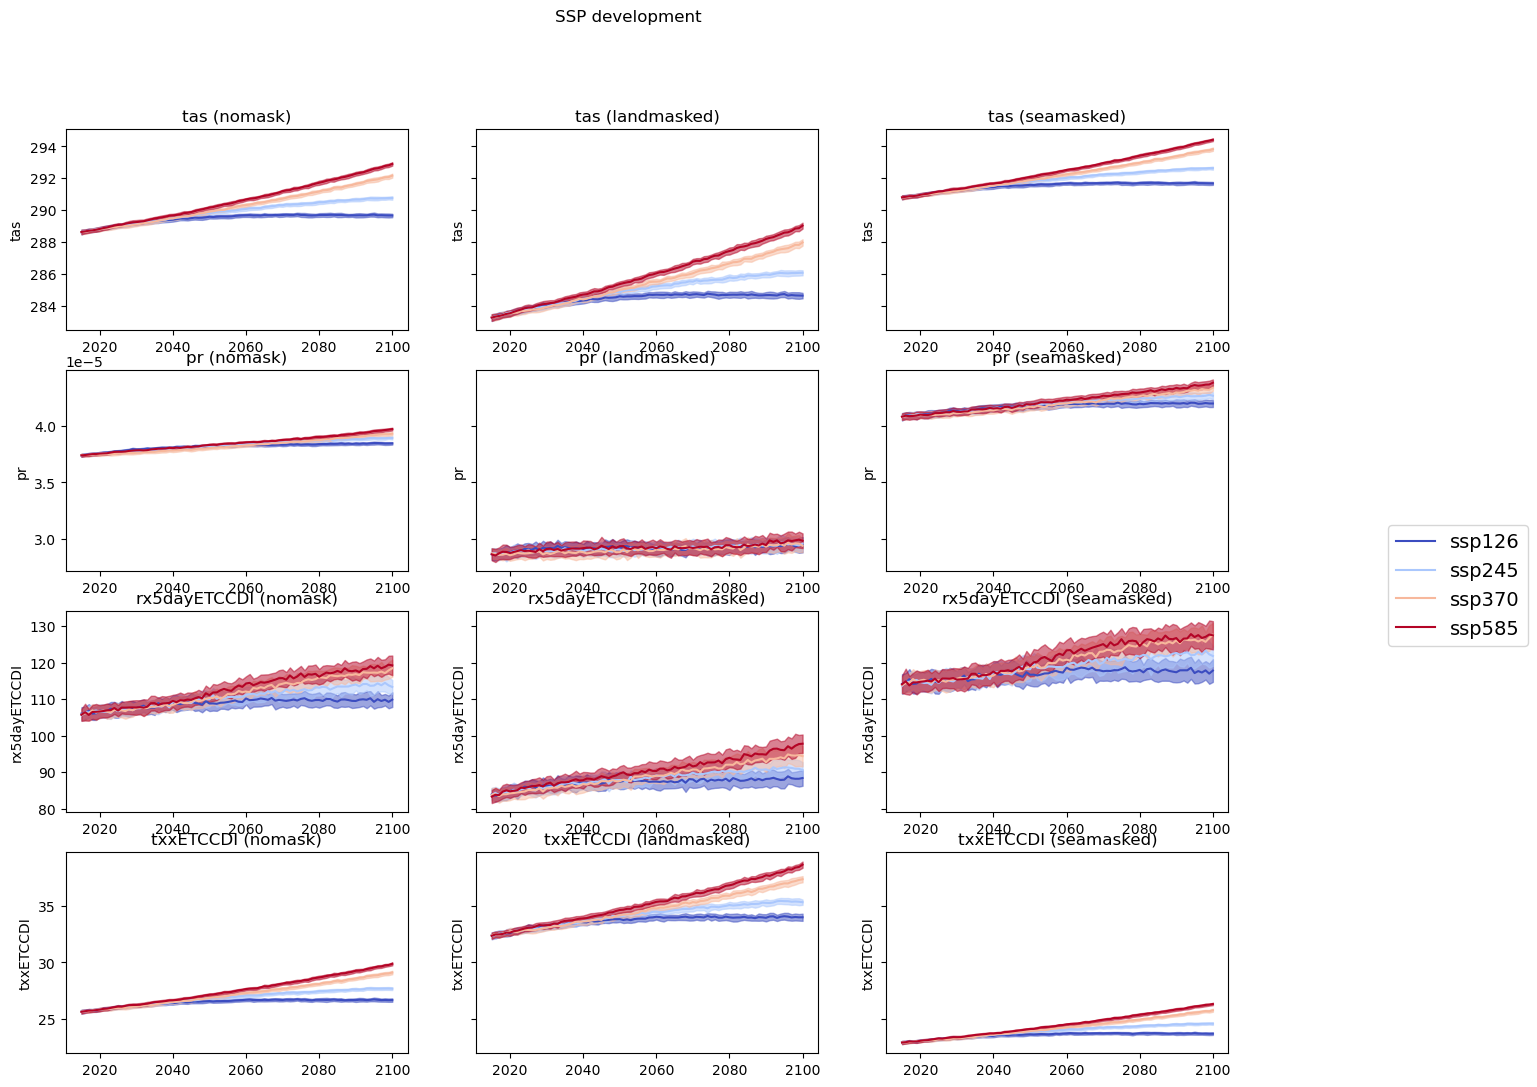

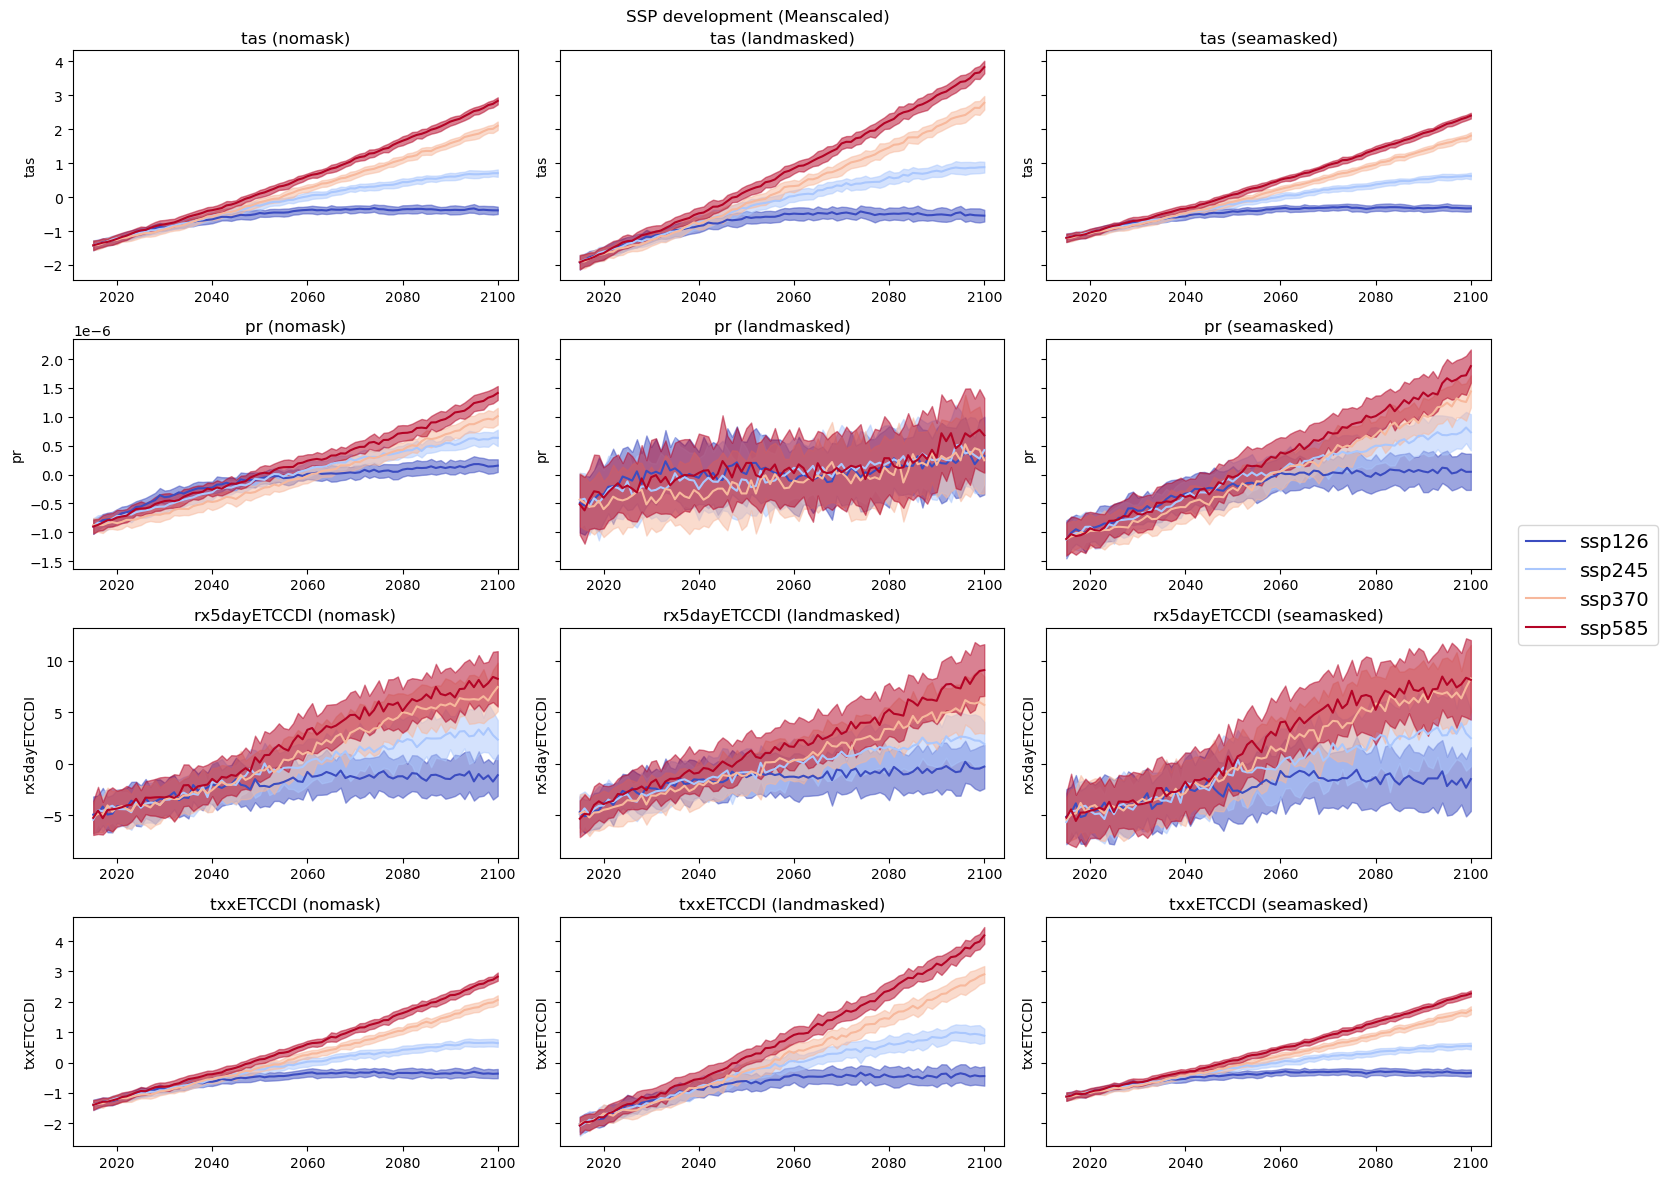

In [103]:

fig, axs = plt.subplots(4, 3, figsize=(15, 12), sharey='row')#, sharex='col')
fig2, axs2 = plt.subplots(4, 3, figsize=(15, 12), sharey='row')#, sharex='col')

fig.suptitle('SSP development')
fig2.suptitle('SSP development (Meanscaled)')

main_data_dir = 'D:/Programmering/msc/Masterthesis_S23_DataFiles/AnnualGlobalClimatologies'
masks = ['nomask', 'landmasked', 'seamasked']
SSPs = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
variables = ['tas', 'pr', 'rx5dayETCCDI', 'txxETCCDI']

colors = plt.cm.coolwarm(np.linspace(0, 1, len(SSPs)))
color_map = dict(zip(SSPs, colors))

for i, mask in enumerate(masks):
    
    for j, variable in enumerate(variables):
        axs[j, i].set_ylabel(variable)
        axs[j, i].set_title(f'{variable} ({mask})')
        axs2[j, i].set_ylabel(variable)
        axs2[j, i].set_title(f'{variable} ({mask})')

        means = {}
        stds = {}
        for scenario in SSPs:
            data_dir = '/'.join([main_data_dir, mask, variable, scenario])
            
            ens = ensembles.create_ensemble(Path(data_dir).glob("*.nc"))
            ens_stats = ensembles.ensemble_mean_std_max_min(ens)
            
            ens_mean = ens_stats[f'{variable}_mean']
            ens_std = ens_stats[f'{variable}_stdev']
            axs[j, i].plot(ens_stats.year, ens_mean, 
                           label=scenario,
                           color=color_map[scenario])
            axs[j, i].fill_between(ens_stats.year, ens_mean - ens_std, ens_mean + ens_std, 
                                   color=color_map[scenario],
                                   alpha=0.5)

            means[scenario] = ens_mean
            stds[scenario] = ens_std
        
        subfig_mean = [scenario_mean.mean().values.item() for scenario_mean in means.values()]
        subfig_mean = np.mean(subfig_mean)

        for scenario in means.keys(): 
            # meanscaled version
            # Kan ikke skalere med gruppegjennomsnittet må benytte gjennomsnittet av alle sspene
            meanscaled_ens_mean = means[scenario] - subfig_mean
            axs2[j, i].fill_between(ens_stats.year, meanscaled_ens_mean - stds[scenario], meanscaled_ens_mean + stds[scenario], 
                                   color=color_map[scenario],
                                   alpha=0.5)
            axs2[j, i].plot(ens_stats.year, meanscaled_ens_mean, 
                            label=scenario,
                            color=color_map[scenario])
            

legend_without_duplicate_labels(fig)
legend_without_duplicate_labels(fig2)
plt.tight_layout()
plt.show()

### Datawrangling for table creation

In [99]:
def extract_cross_sections(main_data_dir, masks, SSPs):
    
    data_frames = {}
    for year in range(2015, 2101):
        data_frames[year] = pd.DataFrame(columns=['mask', 'SSP', 'year', 'tas', 'pr', 'rx5dayETCCDI', 'txxETCCDI'], 
                                         index=range(len(masks)*len(SSPs)*40))
    
    indx = 0
    for mask in masks:
        for scenario in SSPs:
            data_dir = '/'.join([main_data_dir, mask, 'multivariate', scenario])
            file_names = file_handler.get_all_netcdf_files_in_dir(data_dir)
            
            for file_name in file_names:

                ds = file_handler.read_netcdf_to_xr(directory=data_dir, 
                                                    file_name=file_name)
                
                for year in range(2015, 2101):
                    ds_year = ds.sel(year=year)
                    data_frames[year].loc[indx] = [mask, scenario, ds_year.year.values.item(),
                                                ds_year.tas.values.item(), 
                                                ds_year.pr.values.item(), 
                                                ds_year.rx5dayETCCDI.values.item(), 
                                                ds_year.txxETCCDI.values.item()]
                
                indx += 1   
    return data_frames            

In [100]:
masks = ['nomask', 'landmasked', 'seamasked']

data_frames = extract_cross_sections(main_data_dir, masks, SSPs)

In [98]:
import os

main_save_dir = 'D:/Programmering/msc/Masterthesis_S23_DataFiles/AnnualGlobalClimatologies/tables'

for year, df in data_frames.items():
    file_name = f"tab_glob_yr_climatology_{year}.csv"
    file_path = os.path.join(main_save_dir, file_name)
    df.to_csv(file_path, index=False)


### Boxplots 
one for every fift years?


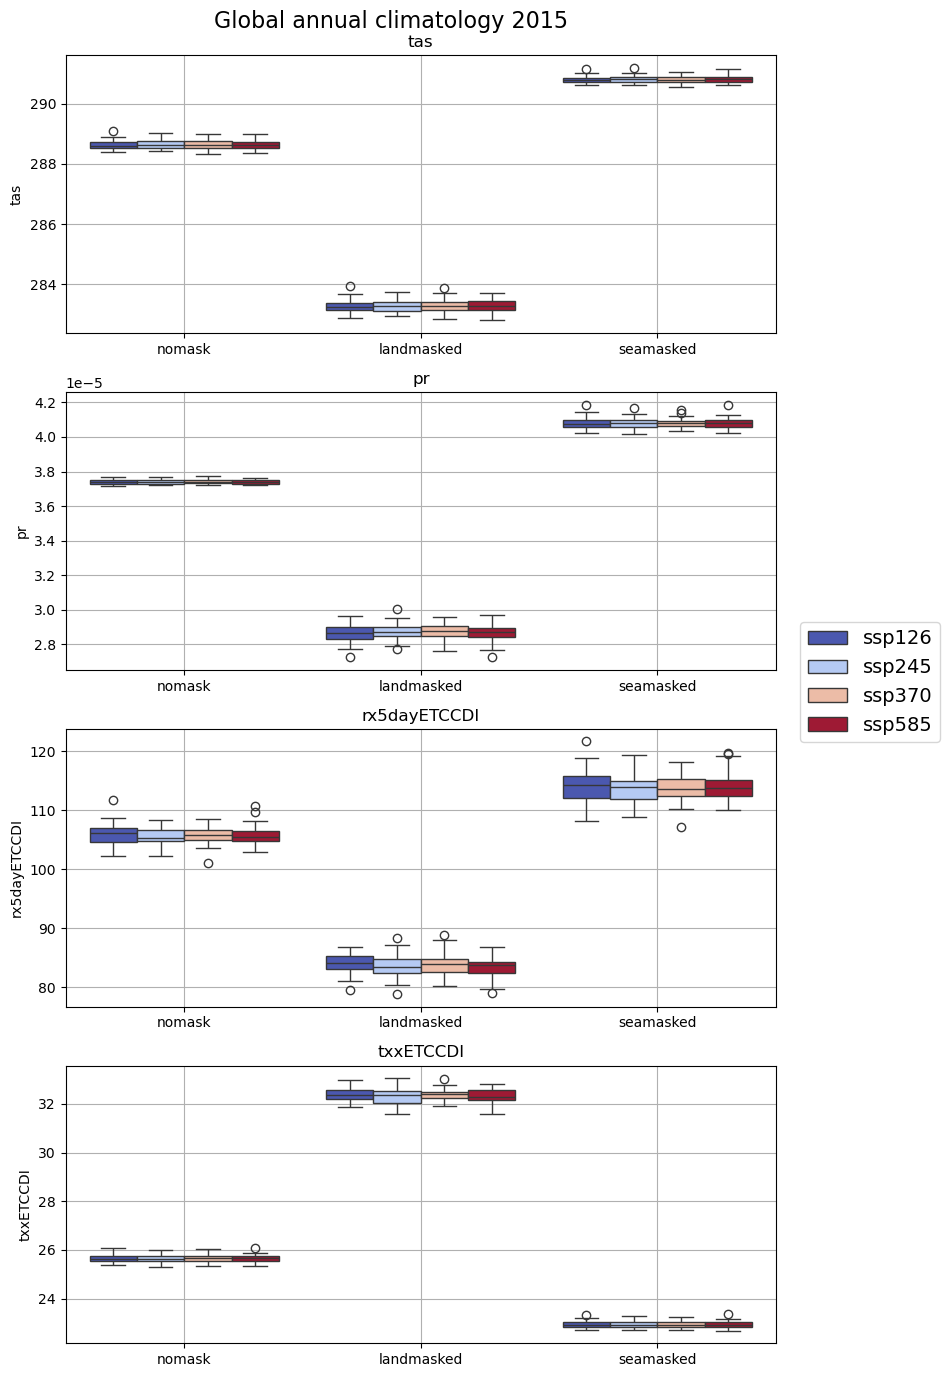

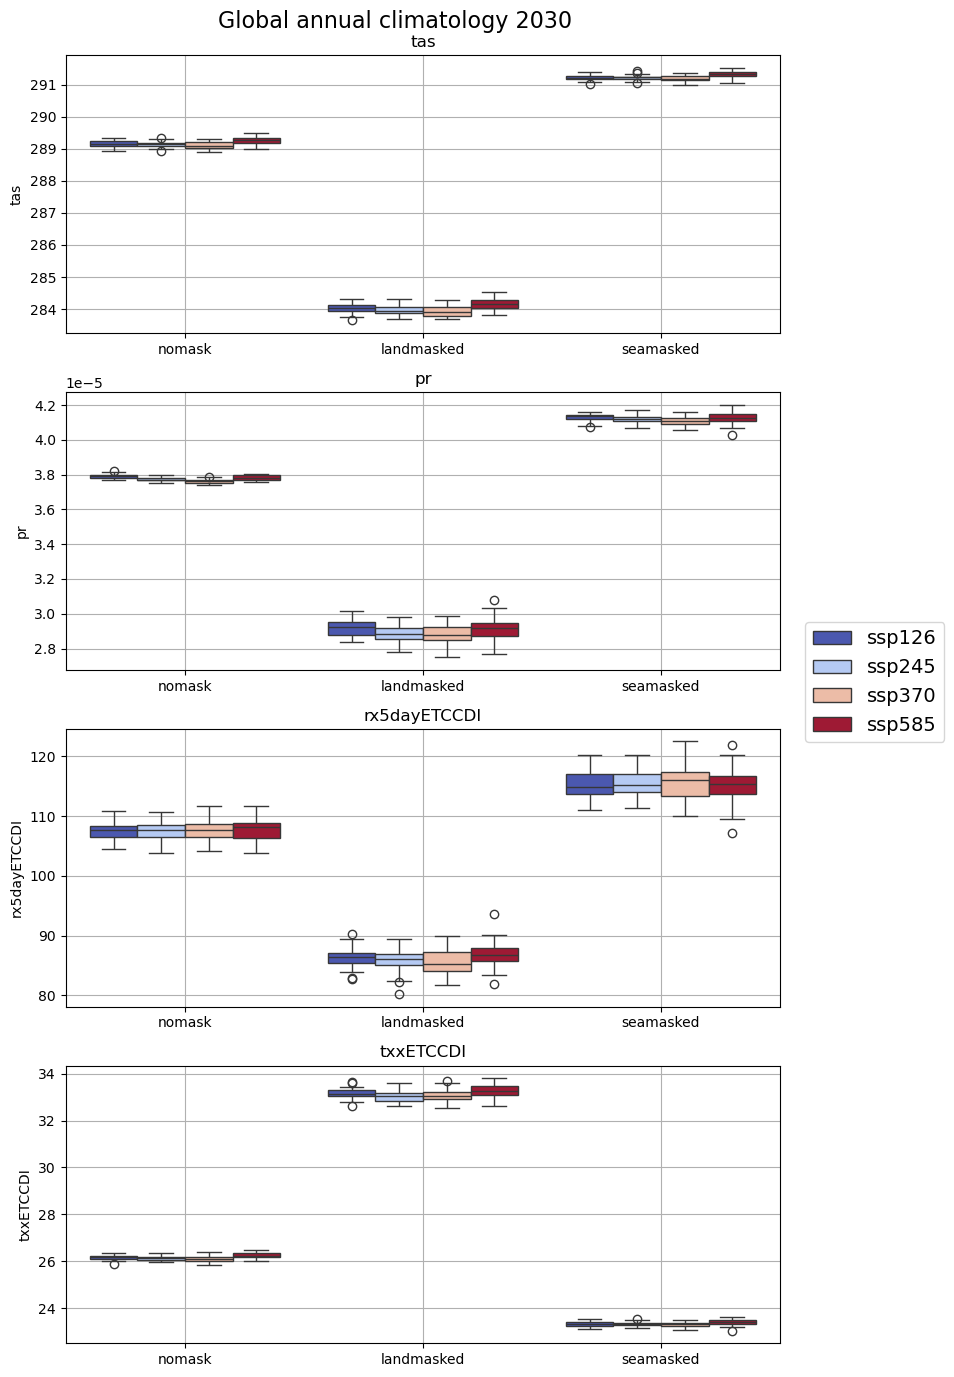

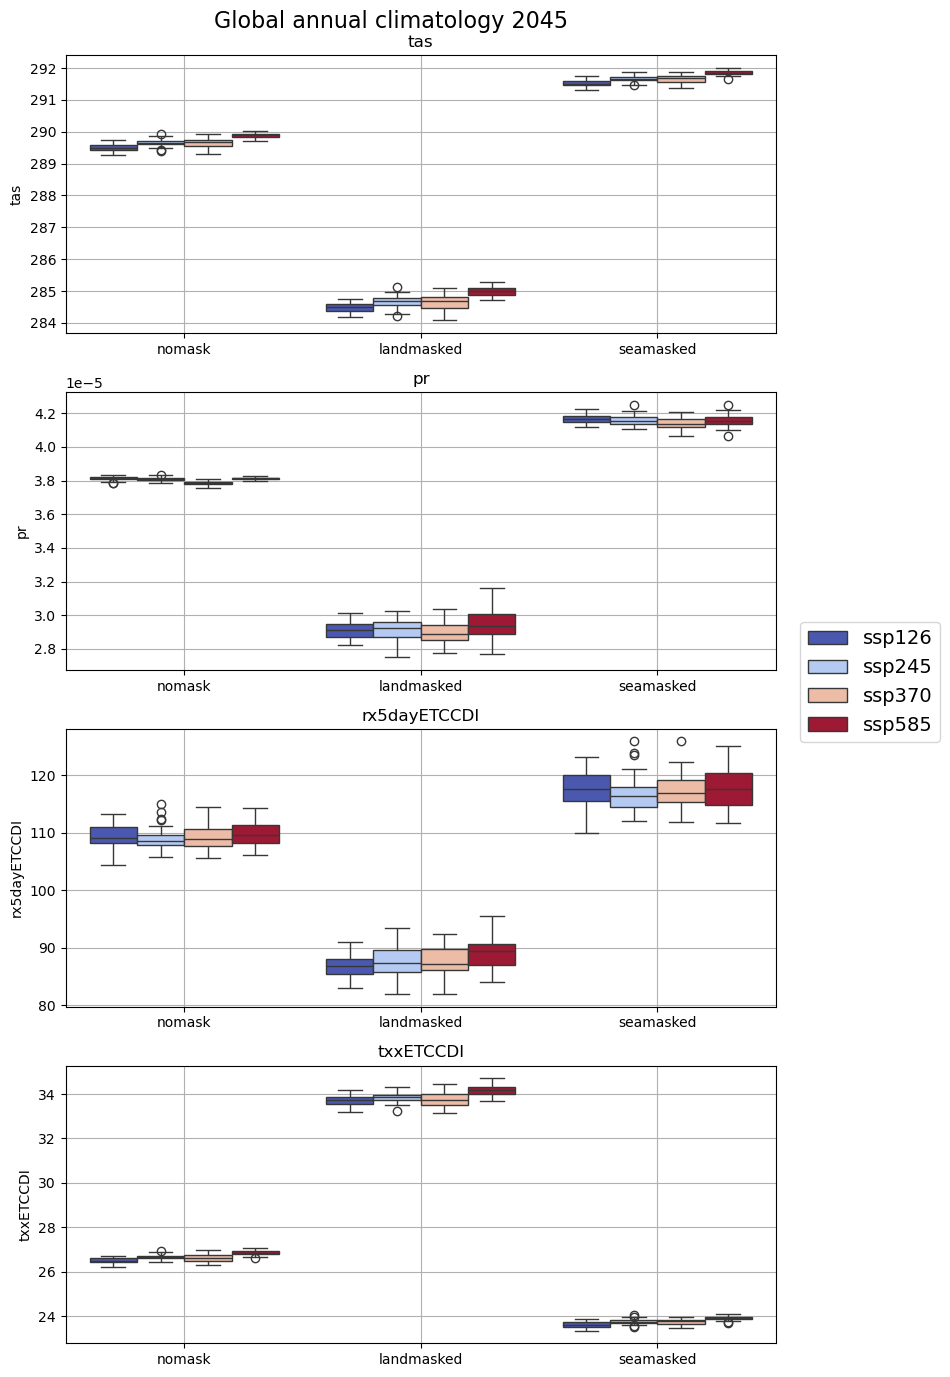

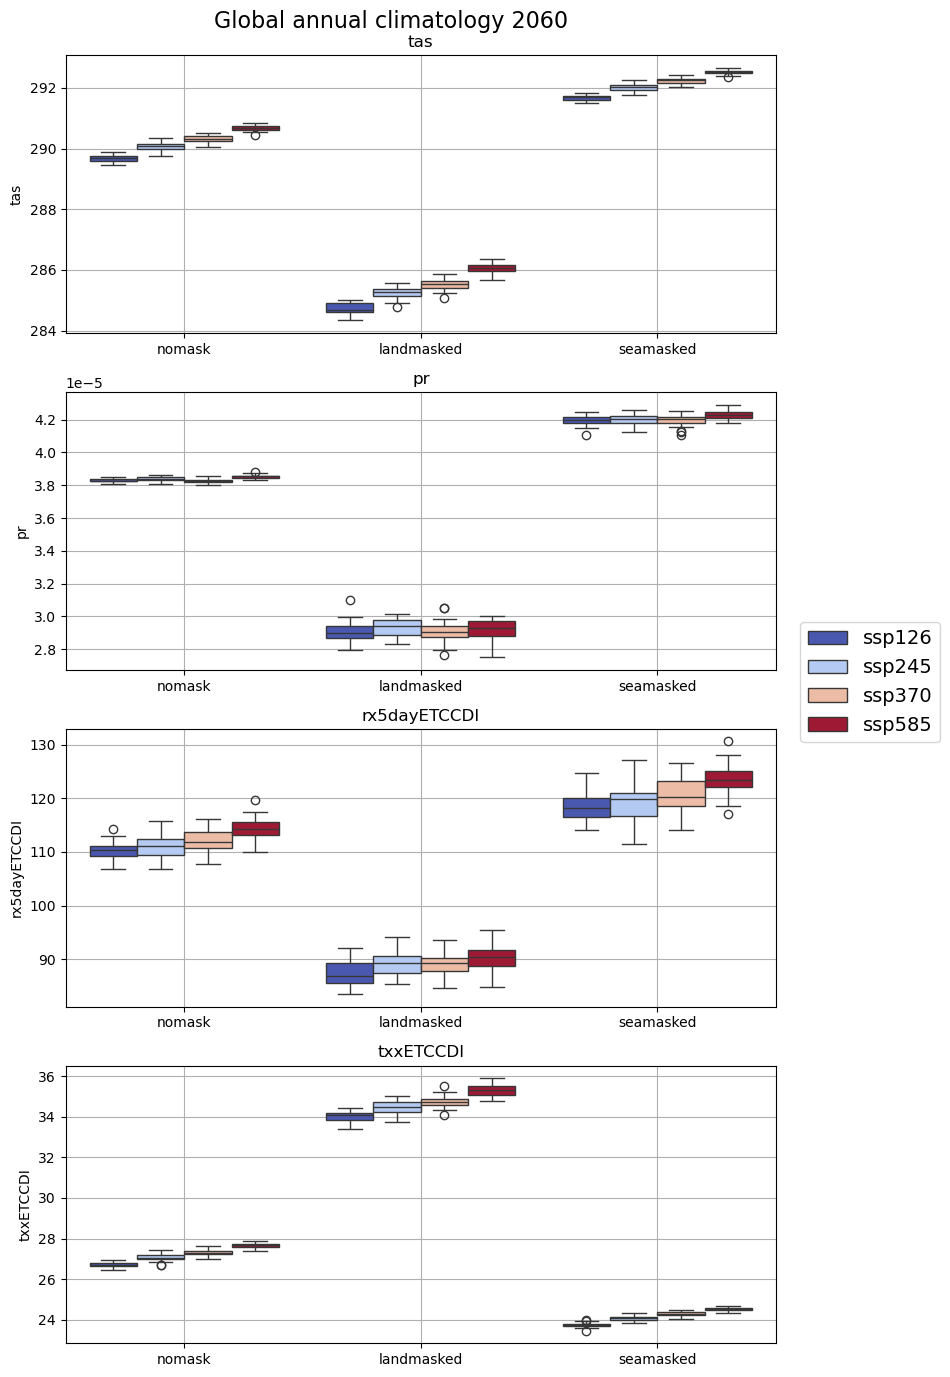

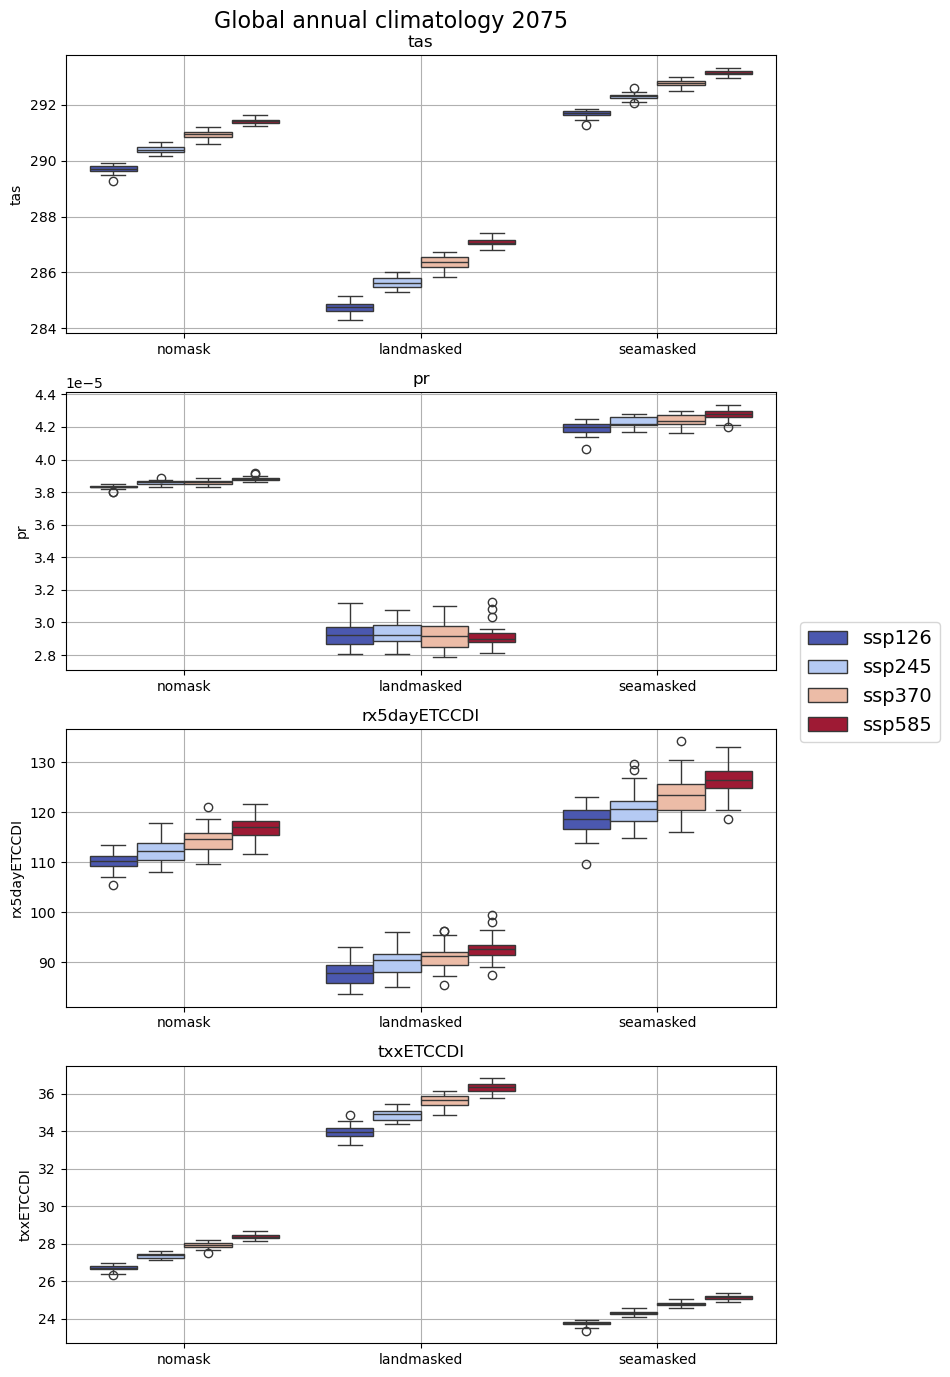

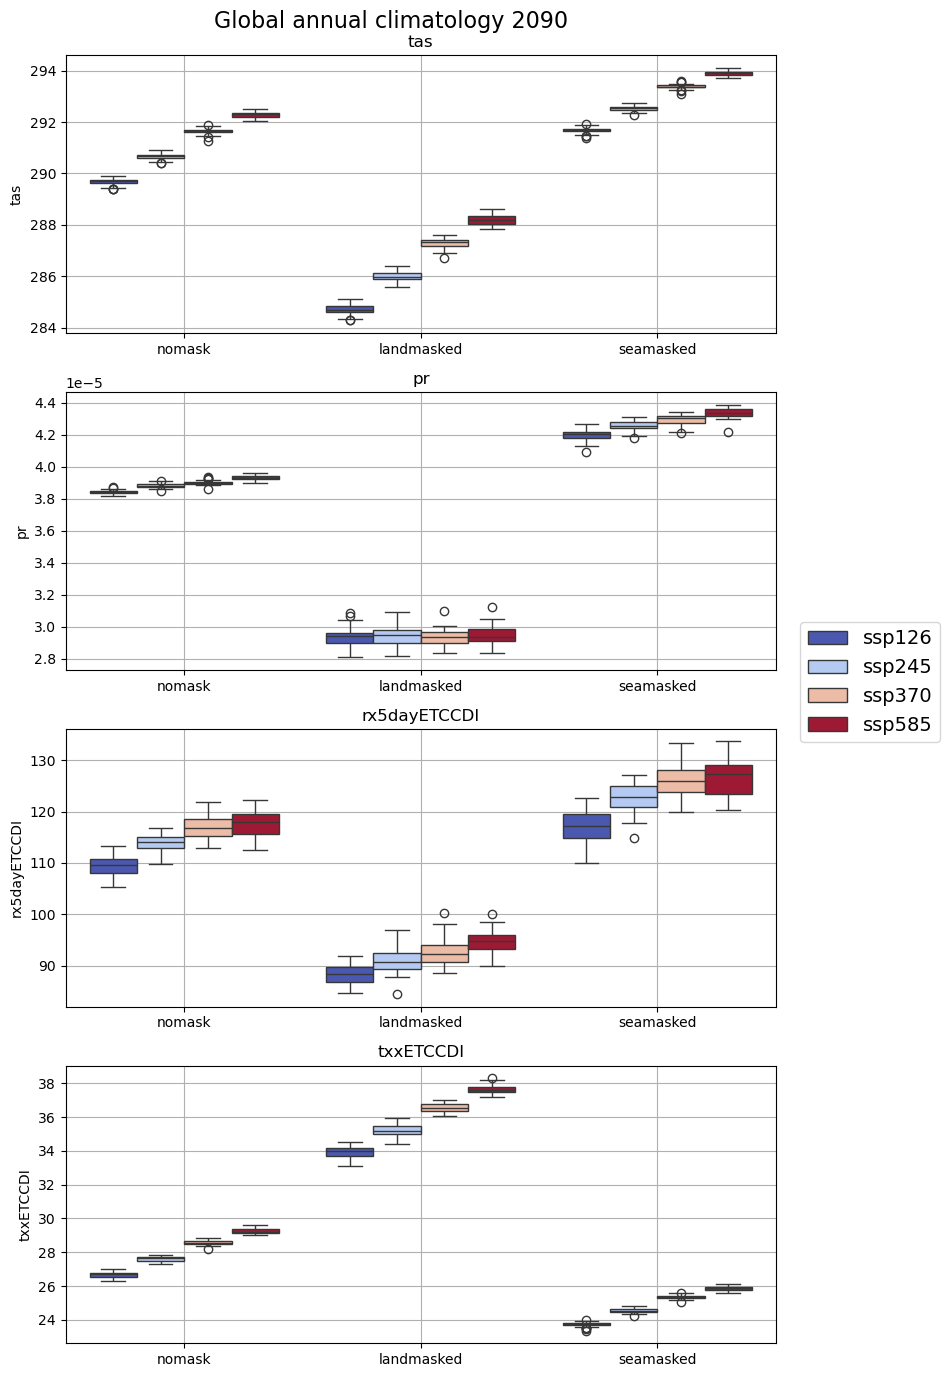

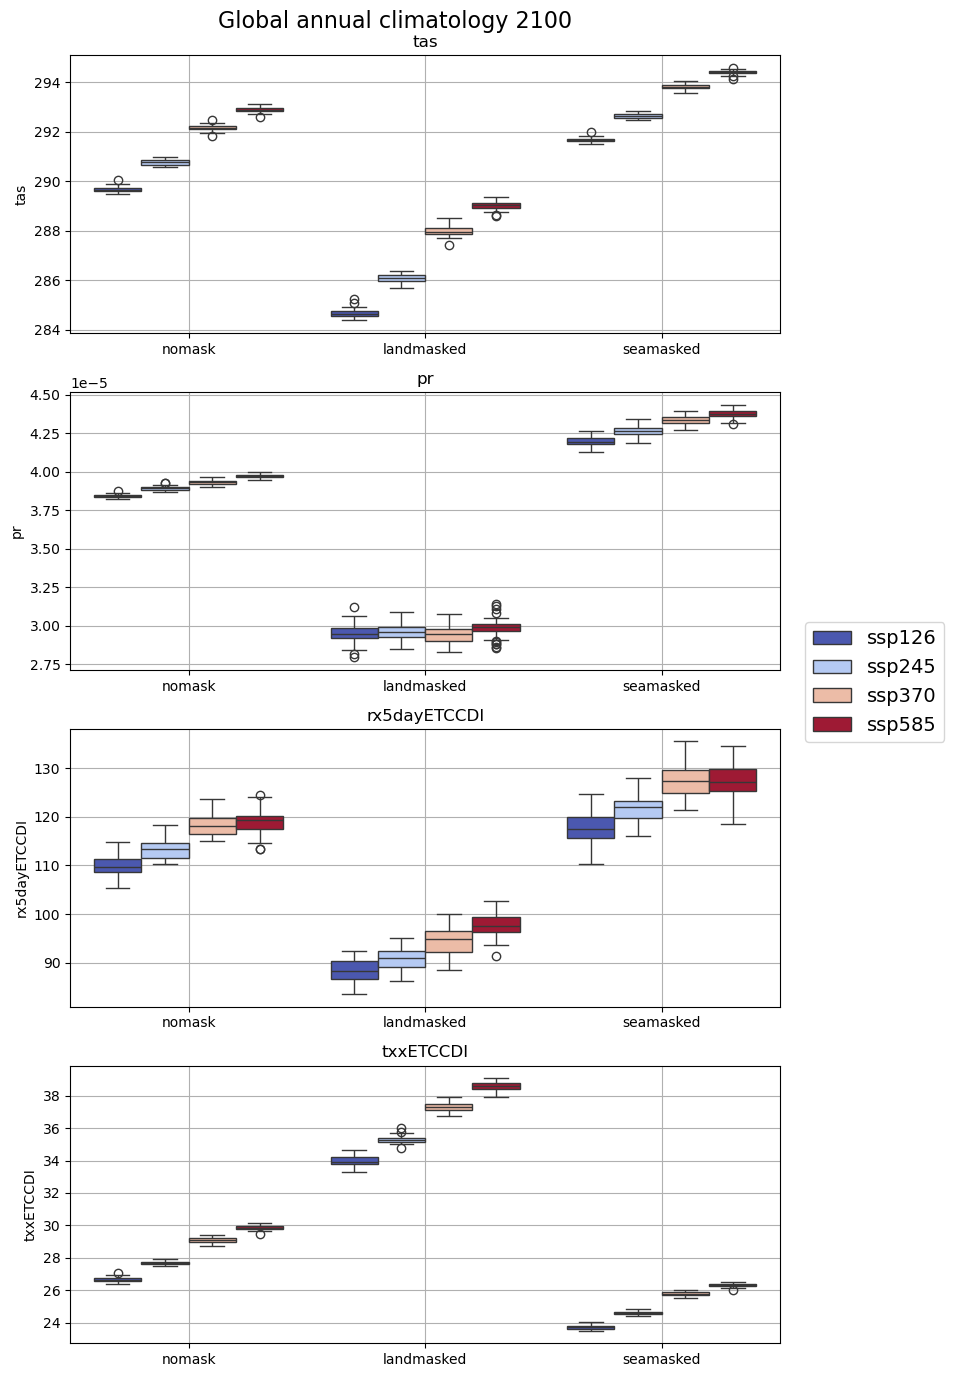

In [127]:
years = [2015, 2030, 2045, 2060, 2075, 2090, 2100]

for year in years:
    # Create a figure with four subplots
    fig, axs = plt.subplots(4, 1, figsize=(8, 14))
    fig.suptitle(f'Global annual climatology {year}', fontsize=16)

    df = data_frames[year]
    # Iterate over each variable
    for i, variable in enumerate(variables):
        # Get the data frame for the variable
        df_variable = df[['SSP', 'mask', variable]]
        
        # Create a boxplot for each SSP and each mask
        ax = axs[i]
        sns.boxplot(x='mask', 
                    y=variable, 
                    hue='SSP', 
                    data=df_variable, 
                    ax=ax, 
                    palette=color_map)
        ax.set_title(variable)
        ax.set_xlabel('')
        ax.set_ylabel(variable)
        ax.grid(True)
        ax.get_legend().remove()

    legend_without_duplicate_labels(fig)
    plt.tight_layout()
    plt.show()


## MANOVA

### MANOVA adequacy checking
s. 167


### MANOVA testing

### Post-hoc Linear disciminant analysis (LDA)